Importing standard libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

from math import sin, cos, sqrt, atan2, radians

In [2]:
plt.style.use('seaborn')

In [3]:
# Predefining the data files in a dictionary for easy file maintenance
data_files = {
    'train' : '../assets/train.csv',
    'test' : '../assets/test.csv',
    'spray' : '../assets/spray.csv',
    'weather' : '../assets/weather.csv',
    'mapdata_rds' : '../assets/mapdata_copyright_openstreetmap_contributors.rds',
    'mapdata_txt' : '../assets/mapdata_copyright_openstreetmap_contributors.txt',
    'shp' : '../assets/Boundaries_cities/geo_export_095d1d3d-b302-4bae-8a12-f6f48cb71b9f.shp',
    'submit' : '../assets/submission.csv'
}

In [4]:
# NA options to use for read_csv
na_opt = {
    'train' : None,
    'test' : None,
    'spray' : None,
    'weather' : ['M','-']
}

In [5]:
# Prededefine dictionary to hold all data
all_data = dict()

In [6]:
# Loading csv files into DataFrame
for file in list(data_files.keys())[:4]:
    key = f'{file}_df'
    print('-----------------------------------')
    print(f'Loading DataFrame for {file} data')
    print('-----------------------------------')
    all_data[key] = pd.read_csv(data_files[file], na_values=na_opt[file])
    print(f'shape for {file}: {all_data[key].shape}\n')

-----------------------------------
Loading DataFrame for train data
-----------------------------------
shape for train: (10506, 12)

-----------------------------------
Loading DataFrame for test data
-----------------------------------
shape for test: (116293, 11)

-----------------------------------
Loading DataFrame for spray data
-----------------------------------
shape for spray: (14835, 4)

-----------------------------------
Loading DataFrame for weather data
-----------------------------------
shape for weather: (2944, 22)



In [7]:
# Checking column information
for data in all_data.keys():
    print('-----------------------------------')
    print(f'check column information for {data}')
    display(all_data[data].info())

-----------------------------------
check column information for train_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Species                 10506 non-null  object 
 3   Block                   10506 non-null  int64  
 4   Street                  10506 non-null  object 
 5   Trap                    10506 non-null  object 
 6   AddressNumberAndStreet  10506 non-null  object 
 7   Latitude                10506 non-null  float64
 8   Longitude               10506 non-null  float64
 9   AddressAccuracy         10506 non-null  int64  
 10  NumMosquitos            10506 non-null  int64  
 11  WnvPresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


None

-----------------------------------
check column information for test_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Id                      116293 non-null  int64  
 1   Date                    116293 non-null  object 
 2   Address                 116293 non-null  object 
 3   Species                 116293 non-null  object 
 4   Block                   116293 non-null  int64  
 5   Street                  116293 non-null  object 
 6   Trap                    116293 non-null  object 
 7   AddressNumberAndStreet  116293 non-null  object 
 8   Latitude                116293 non-null  float64
 9   Longitude               116293 non-null  float64
 10  AddressAccuracy         116293 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 9.8+ MB


None

-----------------------------------
check column information for spray_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14251 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


None

-----------------------------------
check column information for weather_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2933 non-null   float64
 5   Depart       1472 non-null   float64
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2940 non-null   float64
 8   Heat         2933 non-null   float64
 9   Cool         2933 non-null   float64
 10  Sunrise      1472 non-null   float64
 11  Sunset       1472 non-null   float64
 12  CodeSum      2944 non-null   object 
 13  Depth        1472 non-null   float64
 14  Water1       0 non-null      float64
 15  SnowFall     1472 non-null   object 
 16  PrecipTotal  2942 non-null   object 
 17  StnPressure  2

None

In [8]:
# Checking for Null
for data in all_data.keys():
    print('-----------------------------------')
    print(f'checking for null in {data}')
    display(all_data[data].isnull().sum())

-----------------------------------
checking for null in train_df


Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
dtype: int64

-----------------------------------
checking for null in test_df


Id                        0
Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
dtype: int64

-----------------------------------
checking for null in spray_df


Date           0
Time         584
Latitude       0
Longitude      0
dtype: int64

-----------------------------------
checking for null in weather_df


Station           0
Date              0
Tmax              0
Tmin              0
Tavg             11
Depart         1472
DewPoint          0
WetBulb           4
Heat             11
Cool             11
Sunrise        1472
Sunset         1472
CodeSum           0
Depth          1472
Water1         2944
SnowFall       1472
PrecipTotal       2
StnPressure       4
SeaLevel          9
ResultSpeed       0
ResultDir         0
AvgSpeed          3
dtype: int64

In [9]:
train_df = all_data['train_df']

In [10]:
train_df.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [11]:
# 95% of the traps were negative for WNV
train_df['WnvPresent'].value_counts(normalize=True)

0    0.947554
1    0.052446
Name: WnvPresent, dtype: float64

In [12]:
# Converting Date column to datetime
train_df['Date'] = pd.to_datetime(train_df['Date'])
# Creating year and month columns
train_df['year'] = train_df['Date'].dt.year
train_df['month'] = train_df['Date'].dt.month
train_df['day'] = train_df['Date'].dt.day
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10506 non-null  datetime64[ns]
 1   Address                 10506 non-null  object        
 2   Species                 10506 non-null  object        
 3   Block                   10506 non-null  int64         
 4   Street                  10506 non-null  object        
 5   Trap                    10506 non-null  object        
 6   AddressNumberAndStreet  10506 non-null  object        
 7   Latitude                10506 non-null  float64       
 8   Longitude               10506 non-null  float64       
 9   AddressAccuracy         10506 non-null  int64         
 10  NumMosquitos            10506 non-null  int64         
 11  WnvPresent              10506 non-null  int64         
 12  year                    10506 non-null  int64 

In [13]:
list(train_df['year'].unique())

[2007, 2009, 2011, 2013]

In [14]:
train_df['year'].value_counts()

2007    3811
2013    2392
2009    2249
2011    2054
Name: year, dtype: int64

In [15]:
# (added 14 Sep 2020)
# weather stations
weather_stns ={
    'station1' : {
        'name': "CHICAGO O'HARE INTERNATIONAL AIRPORT",
        'lon': -87.933,
        'lat': 41.995,
        'elev': 662
    },
    'station2' : {
        'name': "CHICAGO MIDWAY INTL ARPT",
        'lon': -87.752,
        'lat': 41.786,
        'elev': 612
    }
}

In [16]:
# (added 14 Sep 2020)
# Function to calculate distance between 2 sets of longitude and latitude
def cal_distance(lat1, lon1, lat2, lon2):
    """ 
    # Function to calculate distance between 2 sets of longitude and latitude
    
    Parameters: 
		lat1 (float): latitude of the first location
        lon1 (float): longtitude of the first location
        lat2 (float): latitude of the second location
        lon2 (float): longtitude of the second location
  
    Returns: 
		float: distance between the 2 locations in km 
  
    """
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    # 6373.0 approximate radius of earth in km
    return round(6373.0 * c, 4)

In [17]:
# (added 14 Sep 2020)
# Function to calculate the nearest weather station and distance
def nearest_stn(df):
    """ 
    # Function to calculate the nearest weather station and distance
    
    Parameters: 
		df (DataFrame): DataFrame with holding the position information
  
    Returns: 
		None: 
  
    """
    for i in range(len(df)):
        
        lat = df.loc[i, "Latitude"]
        lon = df.loc[i, "Longitude"]
        
        stn1 = abs(cal_distance(lat, lon, 
                            weather_stns['station1']['lat'], 
                            weather_stns['station1']['lon']))
        stn2 = abs(cal_distance(lat, lon, 
                            weather_stns['station2']['lat'], 
                            weather_stns['station2']['lon']))
        
        if stn1 < stn2:
            df.loc[i, "Station"] = 1
            df.loc[i, "stn_distance"] = stn1
        else:
            df.loc[i, "Station"] = 2
            df.loc[i, "stn_distance"] = stn2
    return

In [18]:
# get nearest weather station for train_df
nearest_stn(train_df)

In [19]:
# distance between the 2 weather stations
dist = cal_distance(weather_stns['station1']['lat'],
                    weather_stns['station1']['lon'],
                    weather_stns['station2']['lat'], 
                    weather_stns['station2']['lon'])
print(f'Distance between the 2 weather stations is: {dist}km')

Distance between the 2 weather stations is: 27.6593km


In [20]:
train_df.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,year,month,day,Station,stn_distance
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,2007,5,29,1.0,11.8011
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,2007,5,29,1.0,11.8011
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,2007,5,29,1.0,13.5342
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,2007,5,29,1.0,9.2424
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,2007,5,29,1.0,9.2424


In [21]:
train_df['month'].value_counts(normalize=True)

8     0.357034
7     0.248049
9     0.211117
6     0.149534
10    0.026271
5     0.007995
Name: month, dtype: float64

In [22]:
# Check for rows that have NumMosquitos == 50, potentially have to merge with another row
train_df[train_df['NumMosquitos']>=50]

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,year,month,day,Station,stn_distance
293,2007-07-11,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,50,0,2007,7,11,2.0,12.5335
295,2007-07-11,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,50,0,2007,7,11,2.0,12.5335
350,2007-07-11,"3500 West 116th Street, Chicago, IL 60655, USA",CULEX PIPIENS/RESTUANS,35,W 116TH ST,T158,"3500 W 116TH ST, Chicago, IL",41.682587,-87.707973,9,50,0,2007,7,11,2.0,12.0692
351,2007-07-11,"3500 West 116th Street, Chicago, IL 60655, USA",CULEX PIPIENS/RESTUANS,35,W 116TH ST,T158,"3500 W 116TH ST, Chicago, IL",41.682587,-87.707973,9,50,0,2007,7,11,2.0,12.0692
353,2007-07-11,"3500 West 116th Street, Chicago, IL 60655, USA",CULEX PIPIENS/RESTUANS,35,W 116TH ST,T158,"3500 W 116TH ST, Chicago, IL",41.682587,-87.707973,9,50,0,2007,7,11,2.0,12.0692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10240,2013-09-12,"South Doty Avenue, Chicago, IL, USA",CULEX PIPIENS/RESTUANS,12,S DOTY AVE,T115,"1200 S DOTY AVE, Chicago, IL",41.673408,-87.599862,5,50,1,2013,9,12,2.0,17.7857
10242,2013-09-12,"South Doty Avenue, Chicago, IL, USA",CULEX PIPIENS/RESTUANS,12,S DOTY AVE,T115,"1200 S DOTY AVE, Chicago, IL",41.673408,-87.599862,5,50,0,2013,9,12,2.0,17.7857
10259,2013-09-12,"ORD Terminal 5, O'Hare International Airport, ...",CULEX PIPIENS/RESTUANS,10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,50,0,2013,9,12,1.0,4.1695
10262,2013-09-12,"ORD Terminal 5, O'Hare International Airport, ...",CULEX PIPIENS/RESTUANS,10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,50,0,2013,9,12,1.0,4.1695


In [23]:
train_df['Species'].value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

---
## Spray DataFrame

In [24]:
spray_df = all_data['spray_df']

In [25]:
# Converting Date column to datetime
spray_df['Date'] = pd.to_datetime(spray_df['Date'])

# Creating year and month columns
spray_df['year'] = spray_df['Date'].dt.year
spray_df['month'] = spray_df['Date'].dt.month
spray_df['day'] = spray_df['Date'].dt.day
spray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       14835 non-null  datetime64[ns]
 1   Time       14251 non-null  object        
 2   Latitude   14835 non-null  float64       
 3   Longitude  14835 non-null  float64       
 4   year       14835 non-null  int64         
 5   month      14835 non-null  int64         
 6   day        14835 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 811.4+ KB


In [26]:
spray_df['Date'].dt.year.unique()

array([2011, 2013], dtype=int64)

In [27]:
spray_df['Date'].dt.month.unique()

array([8, 9, 7], dtype=int64)

In [28]:
spray_df['Date'].value_counts(normalize=True)

2013-08-15    0.179845
2013-08-29    0.155174
2013-07-17    0.148433
2011-09-07    0.142501
2013-07-25    0.108325
2013-08-22    0.106977
2013-08-08    0.080553
2013-09-05    0.062285
2013-08-16    0.009505
2011-08-29    0.006404
Name: Date, dtype: float64

In [29]:
spray_df.head()

,Date,Time,Latitude,Longitude,year,month,day
0,2011-08-29,6:56:58 PM,42.391623,-88.089163,2011,8,29
1,2011-08-29,6:57:08 PM,42.391348,-88.089163,2011,8,29
2,2011-08-29,6:57:18 PM,42.391022,-88.089157,2011,8,29
3,2011-08-29,6:57:28 PM,42.390637,-88.089158,2011,8,29
4,2011-08-29,6:57:38 PM,42.390410,-88.088858,2011,8,29


In [30]:
spray_df['Date'].value_counts()

2013-08-15    2668
2013-08-29    2302
2013-07-17    2202
2011-09-07    2114
2013-07-25    1607
2013-08-22    1587
2013-08-08    1195
2013-09-05     924
2013-08-16     141
2011-08-29      95
Name: Date, dtype: int64

In [31]:
# distance between the spray info on 2011-08-29, seems very far away
dist = cal_distance(weather_stns['station1']['lat'],
                    weather_stns['station1']['lon'],
                    42.391623, -88.089163)
print(f'Distance between the 2 weather stations is: {dist}km')

Distance between the 2 weather stations is: 45.955km


In [32]:
# distance between the spray info on 2011-09-07, seems very far away
dist = cal_distance(weather_stns['station1']['lat'],
                    weather_stns['station1']['lon'],
                    41.988837, -87.817002)
print(f'Distance between the 2011-09-07 stations is: {dist}km')

Distance between the 2011-09-07 stations is: 9.6141km


---
## Weather DataFrame

In [33]:
w_df = all_data['weather_df']

In [34]:
w_df['Date'] = pd.to_datetime(w_df['Date'])

In [35]:
w_df['Date'].dt.year.unique()

array([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014], dtype=int64)

In [36]:
w_df.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67.0,14.0,51,56.0,0.0,2.0,...,,0.0,NaN,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68.0,NaN,51,57.0,0.0,3.0,...,,NaN,NaN,NaN,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51.0,-3.0,42,47.0,14.0,0.0,...,BR,0.0,NaN,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52.0,NaN,42,47.0,13.0,0.0,...,BR HZ,NaN,NaN,NaN,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56.0,2.0,40,48.0,9.0,0.0,...,,0.0,NaN,0.0,0.00,29.39,30.12,11.7,7,11.9


In [37]:
w_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2933 non-null   float64       
 5   Depart       1472 non-null   float64       
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2940 non-null   float64       
 8   Heat         2933 non-null   float64       
 9   Cool         2933 non-null   float64       
 10  Sunrise      1472 non-null   float64       
 11  Sunset       1472 non-null   float64       
 12  CodeSum      2944 non-null   object        
 13  Depth        1472 non-null   float64       
 14  Water1       0 non-null      float64       
 15  SnowFall     1472 non-null   object        
 16  Precip

In [38]:
# Convert column names into lowercase
w_df.columns = map(str.lower, w_df.columns)

# Split Date (ojbect) into day, month and year
# This will be useful later when EDA and modelling are performed
w_df['year'] = w_df.date.dt.year
w_df['month'] = w_df.date.dt.month
w_df['day'] = w_df.date.dt.day

In [39]:
# Check on the datatype
w_df.dtypes

station                 int64
date           datetime64[ns]
tmax                    int64
tmin                    int64
tavg                  float64
depart                float64
dewpoint                int64
wetbulb               float64
heat                  float64
cool                  float64
sunrise               float64
sunset                float64
codesum                object
depth                 float64
water1                float64
snowfall               object
preciptotal            object
stnpressure           float64
sealevel              float64
resultspeed           float64
resultdir               int64
avgspeed              float64
year                    int64
month                   int64
day                     int64
dtype: object

From the output above, we can see that all columns are numerical except for CodeSum, SnowFall and PrecipTotal. `CodeSum` is the code for weather condition at a given day, so it is sensible that it is not numerical. However, the other 2 columns are ought to be numerical. Let's look into each of the 2 columns to find out if there is any invalid value that is causing it to be categorical.

---
## Snowfall and PrecipTotal Column

In [40]:
# Unique values of SnowFall
w_df.snowfall.unique()

array(['0.0', nan, '  T', '0.1'], dtype=object)

In [41]:
# Unique values of PrecipTotal
w_df.preciptotal.unique()

array(['0.00', '  T', '0.13', '0.02', '0.38', '0.60', '0.14', '0.07',
       '0.11', '0.09', '1.01', '0.28', '0.04', '0.08', '0.01', '0.53',
       '0.19', '0.21', '0.32', '0.39', '0.31', '0.42', '0.27', '0.16',
       '0.58', '0.93', '0.05', '0.34', '0.15', '0.35', nan, '0.40',
       '0.66', '0.30', '0.24', '0.43', '1.55', '0.92', '0.89', '0.17',
       '0.03', '1.43', '0.97', '0.26', '1.31', '0.06', '0.46', '0.29',
       '0.23', '0.41', '0.45', '0.83', '1.33', '0.91', '0.48', '0.37',
       '0.88', '2.35', '1.96', '0.20', '0.25', '0.18', '0.67', '0.36',
       '0.33', '1.28', '0.74', '0.76', '0.71', '0.95', '1.46', '0.12',
       '0.52', '0.64', '0.22', '1.24', '0.72', '0.73', '0.65', '1.61',
       '1.22', '0.50', '1.05', '2.43', '0.59', '2.90', '2.68', '1.23',
       '0.62', '6.64', '3.07', '1.44', '1.75', '0.82', '0.80', '0.86',
       '0.63', '0.55', '1.03', '0.70', '1.73', '1.38', '0.44', '1.14',
       '1.07', '3.97', '0.87', '0.78', '1.12', '0.68', '0.10', '0.61',
       '0.

Here we see that ' T' are present in both the columns. Checking through the data dictionary document shows that the code 'T' actually represents 'Trace' amount of either Snow or Precipitation. We can easily replace the value with 0 since it was only traced amount that was **not measurable by the sensory equipment.**

In [42]:
# Replacing SnowFall 'T' with 0
w_df['snowfall'] = w_df['snowfall'].replace('  T', 0).astype(float)

# Replacing PrecipTotal 'T' with 0
w_df['preciptotal'] = w_df['preciptotal'].replace('  T', 0).astype(float)

# Sanity check on the data type after cleaning
w_df.dtypes

station                 int64
date           datetime64[ns]
tmax                    int64
tmin                    int64
tavg                  float64
depart                float64
dewpoint                int64
wetbulb               float64
heat                  float64
cool                  float64
sunrise               float64
sunset                float64
codesum                object
depth                 float64
water1                float64
snowfall              float64
preciptotal           float64
stnpressure           float64
sealevel              float64
resultspeed           float64
resultdir               int64
avgspeed              float64
year                    int64
month                   int64
day                     int64
dtype: object

## Codesum Column

Only days with weather condition will be recorded in the dataset. Hence, empty strings in this column actually means that it is a weather-wise uneventful day. We can replace all empty string with 'NA' to indicate that.

In [43]:
# Checking on the composition of CodeSum
w_df.codesum.head()

0         
1         
2       BR
3    BR HZ
4         
Name: codesum, dtype: object

In [44]:
# Replace all empty string with 'NA'
w_df.codesum.replace(' ', 'NA', inplace=True)

In [45]:
# Sanity Check
w_df.codesum.head()

0       NA
1       NA
2       BR
3    BR HZ
4       NA
Name: codesum, dtype: object

## Data Exploration

In [46]:
w_df.station.value_counts()

1    1472
2    1472
Name: station, dtype: int64

In [47]:
# Station 1
w_df.groupby('station').get_group(1).isnull().sum()

station           0
date              0
tmax              0
tmin              0
tavg              0
depart            0
dewpoint          0
wetbulb           3
heat              0
cool              0
sunrise           0
sunset            0
codesum           0
depth             0
water1         1472
snowfall          0
preciptotal       0
stnpressure       2
sealevel          5
resultspeed       0
resultdir         0
avgspeed          0
year              0
month             0
day               0
dtype: int64

In [48]:
# Station 2
w_df.groupby('station').get_group(2).isnull().sum()

station           0
date              0
tmax              0
tmin              0
tavg             11
depart         1472
dewpoint          0
wetbulb           1
heat             11
cool             11
sunrise        1472
sunset         1472
codesum           0
depth          1472
water1         1472
snowfall       1472
preciptotal       2
stnpressure       2
sealevel          4
resultspeed       0
resultdir         0
avgspeed          3
year              0
month             0
day               0
dtype: int64

From the missing value above, we can see that `Water1` is totally missing from the dataframe. So we may just drop it straight away. However, there are many columns that are totally missing in Station 2, but not Station 1. 

In [49]:
# Dropping 'Water1' from the dataframe
w_df.drop('water1', axis=1, inplace=True)

In [50]:
w_df[w_df['date'] == '2007-05-03'][['tavg', 'depart', 'heat', 'cool','sunrise', 'sunset', 'depth', 'snowfall']]

,tavg,depart,heat,cool,sunrise,sunset,depth,snowfall
4,56.0,2.0,9.0,0.0,446.0,1851.0,0.0,0.0
5,58.0,NaN,7.0,0.0,NaN,NaN,NaN,NaN


In [51]:
w_df[w_df['date'] == '2007-07-03'][['tavg', 'depart', 'heat', 'cool','sunrise', 'sunset', 'depth', 'snowfall']]

,tavg,depart,heat,cool,sunrise,sunset,depth,snowfall
126,72.0,0.0,0.0,7.0,421.0,1931.0,0.0,0.0
127,73.0,NaN,0.0,8.0,NaN,NaN,NaN,NaN


In [52]:
# Forward filling to replace all missing value at Station 2 with Station 1 data
w_df.fillna(method='ffill', inplace=True)

In [53]:
w_df[w_df['date'] == '2007-05-03'][['tavg', 'depart', 'heat', 'cool','sunrise', 'sunset', 'depth', 'snowfall']]

,tavg,depart,heat,cool,sunrise,sunset,depth,snowfall
4,56.0,2.0,9.0,0.0,446.0,1851.0,0.0,0.0
5,58.0,2.0,7.0,0.0,446.0,1851.0,0.0,0.0


---
## Test DataFrame

In [54]:
test_df = all_data['test_df']

In [55]:
test_df.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


In [56]:
# test_df['Date'].value_counts()

---
## Merging train and weather DataFrames

In [57]:
# (added 15 Sep 2020)
print(f'train_df shape: {train_df.shape}')
print(f'w_df shape:\t{w_df.shape}')

train_df shape: (10506, 17)
w_df shape:	(2944, 24)


In [58]:
# Convert column names into lowercase
train_df.columns = map(str.lower, train_df.columns)

In [59]:
# merging of train_df and w_df 
merged_df = pd.merge(train_df, w_df, on=['date','station'])

In [60]:
merged_df.shape

(10506, 39)

In [61]:
merged_df.head()

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,...,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year_y,month_y,day_y
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,0.0,0.0,29.39,30.11,5.8,18,6.5,2007,5,29
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,0.0,0.0,29.39,30.11,5.8,18,6.5,2007,5,29
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,...,0.0,0.0,29.39,30.11,5.8,18,6.5,2007,5,29
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,0.0,0.0,29.39,30.11,5.8,18,6.5,2007,5,29
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,0.0,0.0,29.39,30.11,5.8,18,6.5,2007,5,29


---
## Merging spray data

In [62]:
spray_df['Date'].dt.year.unique()

array([2011, 2013], dtype=int64)

In [63]:
# (added 16 Sep 2020)
# Function to calculate the nearest spray time and distance
def nearest_spray(df, s_df):
    """ 
    Function to calculate the nearest spray time and distance
    
    Parameters: 
		df (DataFrame): DataFrame with holding the position information
        s_df (): DataFrame with the spray information
  
    Returns: 
		None: 
  
    """
    for i in range(len(df)):
        
        lat = df.loc[i, "Latitude"]
        lon = df.loc[i, "Longitude"]
        
        stn1 = abs(cal_distance(lat, lon, 
                            weather_stns['station1']['lat'], 
                            weather_stns['station1']['lon']))
        stn2 = abs(cal_distance(lat, lon, 
                            weather_stns['station2']['lat'], 
                            weather_stns['station2']['lon']))
        
        if stn1 < stn2:
            df.loc[i, "Station"] = 1
            df.loc[i, "stn_distance"] = stn1
        else:
            df.loc[i, "Station"] = 2
            df.loc[i, "stn_distance"] = stn2
    return

In [64]:
## WORK IN PROGRESS

---
## Analysis of the traps

In [95]:
mask = (train_df['year']==2007) & (train_df['wnvpresent']==1)
train_df[mask][['trap']].value_counts()

trap
T115    36
T138    16
T128     9
T002     8
T086     8
        ..
T080     1
T145     1
T067     1
T066     1
T085     1
Length: 69, dtype: int64

In [91]:
mask = (train_df['year']==2009) & (train_df['wnvpresent']==1)
train_df[mask][['trap']].value_counts()

trap
T903    2
T900    2
T095    2
T230    1
T228    1
T225    1
T221    1
T160    1
T158    1
T102    1
T090    1
T031    1
T013    1
T011    1
T009    1
T002    1
dtype: int64

In [92]:
mask = (train_df['year']==2011) & (train_df['wnvpresent']==1)
train_df[mask][['trap']].value_counts()

trap
T900    18
T903     8
T223     5
T003     3
T225     2
T218     2
T151     2
T114     2
T039     1
T008     1
T013     1
T027     1
T028     1
T031     1
T090     1
T073     1
T081     1
T083     1
T095     1
T115     1
T158     1
T230     1
T002     1
dtype: int64

In [93]:
mask = (train_df['year']==2013) & (train_df['wnvpresent']==1)
train_df[mask][['trap']].value_counts()

trap 
T900     46
T225      8
T013      8
T030      8
T002      8
T233      7
T003      7
T235      7
T027      6
T054      6
T028      6
T009      5
T066      5
T230      5
T228      5
T223      4
T008      4
T226      4
T147      4
T227      4
T115      4
T061      4
T231      4
T011      3
T089      3
T031      3
T033      3
T047      3
T090      3
T151      3
T114      3
T094      3
T221      3
T158      3
T155      3
T035      2
T039      2
T048      2
T128      2
T065      2
T159      2
T220      2
T012      2
T232      2
T082      2
T222      1
T224      1
T236      1
T135      1
T152      1
T054C     1
T063      1
T102      1
T069      1
T073      1
T077      1
T079      1
T095      1
T080      1
dtype: int64

---
## Data Visualization

In [65]:
street_map = gpd.read_file(data_files['shp'])

In [66]:
street_map

,name,objectid,shape_area,shape_len,geometry
0,CHICAGO,1.0,6.450277e+09,845282.931362,"MULTIPOLYGON (((-87.93514 42.00089, -87.93521 ..."


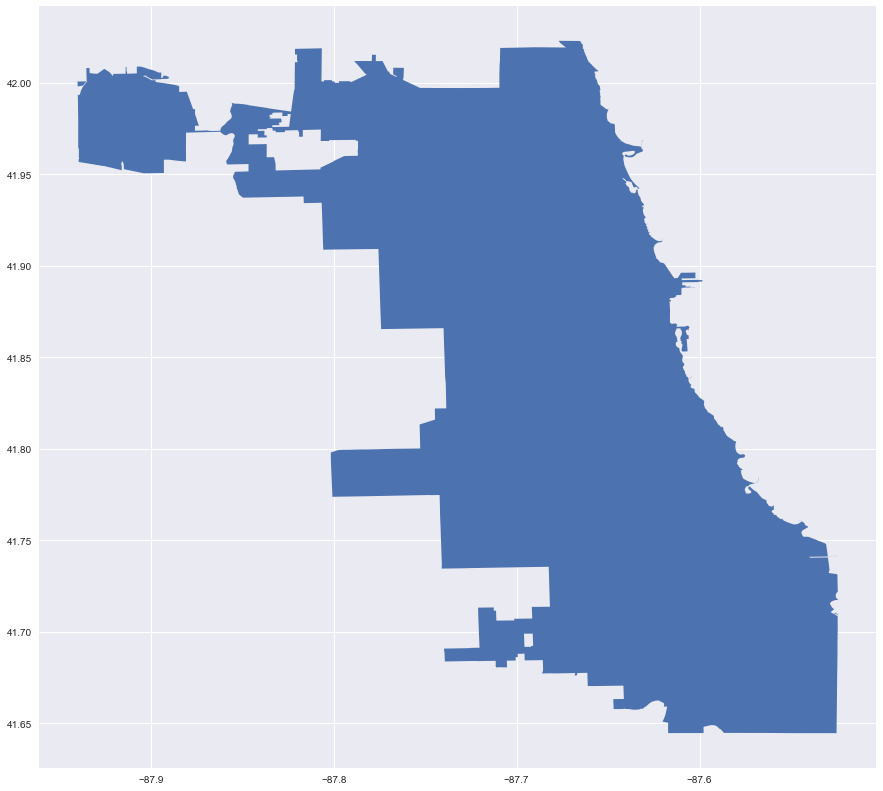

In [67]:
fig,ax = plt.subplots(figsize = (15,15))
street_map.plot(ax=ax);

In [68]:
geo = [Point(xy) for xy in zip(train_df['longitude'], train_df['latitude'])]
geo[:3]

In [69]:
crs = {'init': 'epsg:4326'}
geo_df = gpd.GeoDataFrame(train_df, crs=crs, geometry=geo)
geo_df.head()

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,year,month,day,station,stn_distance,geometry
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,2007,5,29,1.0,11.8011,POINT (-87.80099 41.95469)
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,2007,5,29,1.0,11.8011,POINT (-87.80099 41.95469)
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,2007,5,29,1.0,13.5342,POINT (-87.76928 41.99499)
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,2007,5,29,1.0,9.2424,POINT (-87.82481 41.97409)
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,2007,5,29,1.0,9.2424,POINT (-87.82481 41.97409)


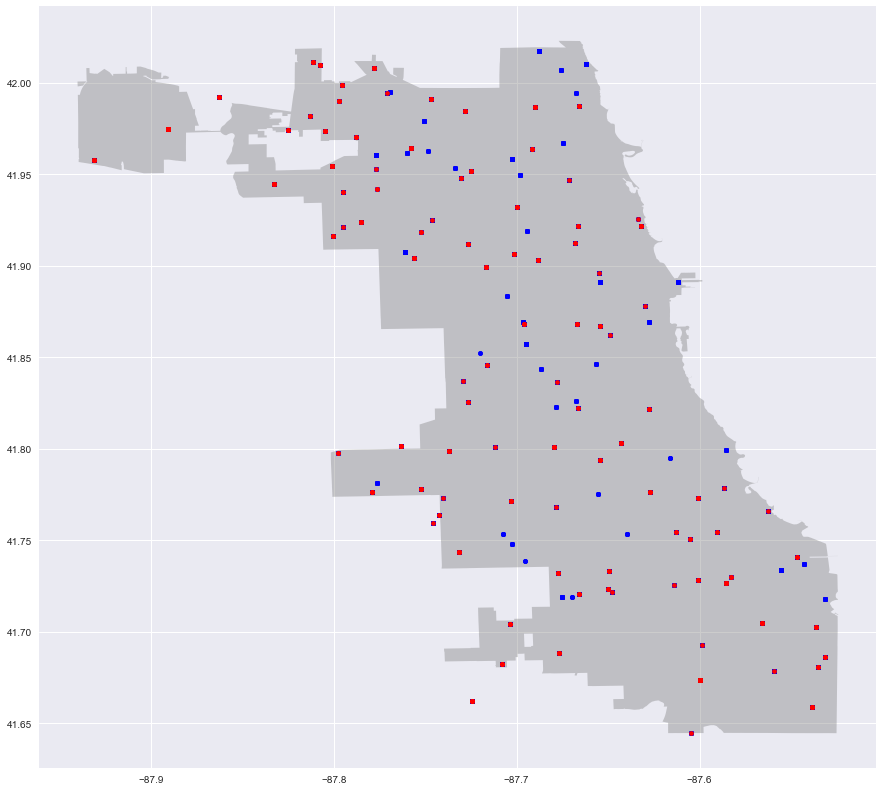

In [70]:
# Plotting the postive and negative classes into the map
fig,ax = plt.subplots(figsize = (15,15))
street_map.plot(ax=ax, alpha = 0.4, color = 'grey')
geo_df[geo_df['wnvpresent']==0].plot(ax=ax, markersize=20, color='blue',marker='o', label='Neg');
geo_df[geo_df['wnvpresent']==1].plot(ax=ax, markersize=20, color='red',marker='o', label='Pos');

In [71]:
# Preparing station locations to be plotted
station = {'station': ['Station1', 'Station2'], 'geometry': [Point(-87.933,41.995), Point(-87.752,41.786)]}
station_df = gpd.GeoDataFrame(station, crs=crs)
station_df

,station,geometry
0,Station1,POINT (-87.93300 41.99500)
1,Station2,POINT (-87.75200 41.78600)


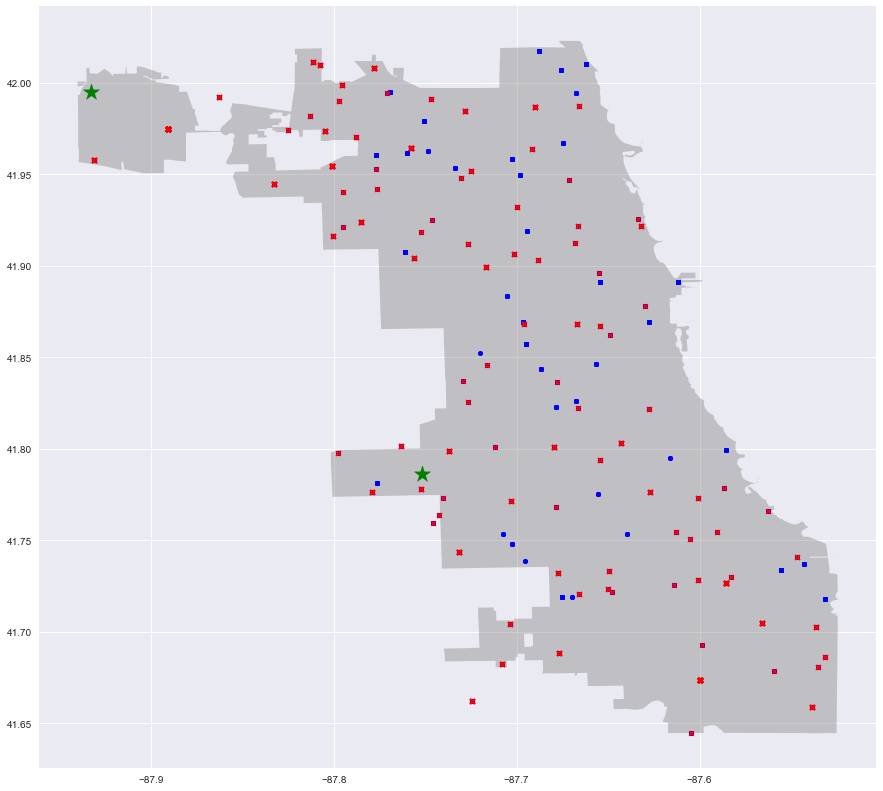

In [72]:
# Plotting the weather stations with postive and negative classes into the map
fig,ax = plt.subplots(figsize = (15,15))
street_map.plot(ax=ax, alpha = 0.4, color = 'grey')
geo_df[geo_df['wnvpresent']==0].plot(ax=ax, markersize=20, color='blue',marker='o', label='Neg')
geo_df[geo_df['wnvpresent']==1].plot(ax=ax, markersize=20, color='red',marker='x', label='Pos')
station_df.plot(ax=ax, markersize=300, color='green',marker='*');

---
## Plotting with Spray information

In [73]:
geo_s = [Point(xy) for xy in zip(spray_df['Longitude'], spray_df['Latitude'])]
geo_s[:3]

In [74]:
geo_spray = gpd.GeoDataFrame(spray_df, crs=crs, geometry=geo_s)
geo_spray.head()

,Date,Time,Latitude,Longitude,year,month,day,geometry
0,2011-08-29,6:56:58 PM,42.391623,-88.089163,2011,8,29,POINT (-88.08916 42.39162)
1,2011-08-29,6:57:08 PM,42.391348,-88.089163,2011,8,29,POINT (-88.08916 42.39135)
2,2011-08-29,6:57:18 PM,42.391022,-88.089157,2011,8,29,POINT (-88.08916 42.39102)
3,2011-08-29,6:57:28 PM,42.390637,-88.089158,2011,8,29,POINT (-88.08916 42.39064)
4,2011-08-29,6:57:38 PM,42.390410,-88.088858,2011,8,29,POINT (-88.08886 42.39041)


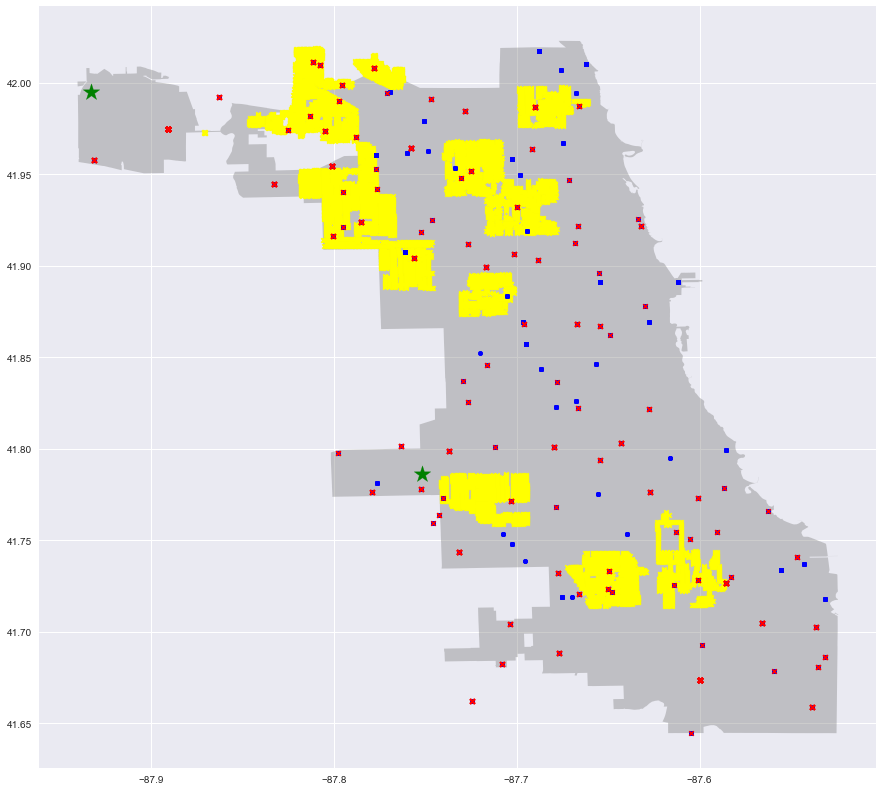

In [75]:
# Combined geo mapping of trap locations, 2 weather stations, and spray area
# Red 'x' - 'WnrPresent' == 1
# Blue 'o' - 'WnrPresent' == 0
# Green '*' - Weather station 1 & 2
# Yellow 'x' - Spray

fig,ax = plt.subplots(figsize = (15,15))
street_map.plot(ax=ax, alpha = 0.4, color = 'grey')
geo_spray[geo_spray['Date']!='2011-08-29'].plot(ax=ax, markersize=20, color='yellow',marker='x')
geo_df[geo_df['wnvpresent']==0].plot(ax=ax, markersize=20, color='blue',marker='o', label='Neg')
geo_df[geo_df['wnvpresent']==1].plot(ax=ax, markersize=20, color='red',marker='x', label='Pos')
station_df.plot(ax=ax, markersize=300, color='green',marker='*');

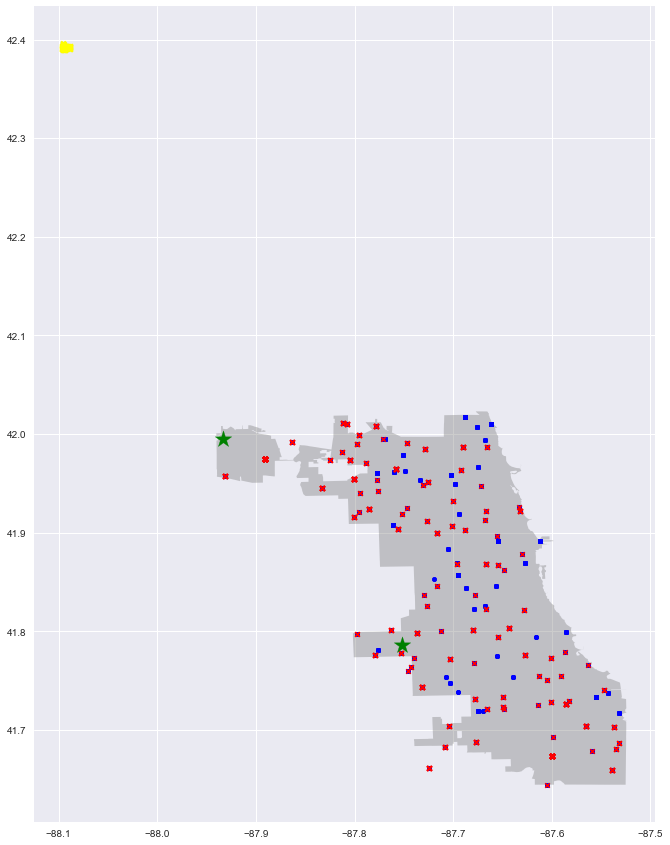

In [76]:
# spray location on date '2011-08-29' 
fig,ax = plt.subplots(figsize = (15,15))
street_map.plot(ax=ax, alpha = 0.4, color = 'grey')
geo_spray[geo_spray['Date']=='2011-08-29'].plot(ax=ax, markersize=20, color='yellow',marker='x')
geo_df[geo_df['wnvpresent']==0].plot(ax=ax, markersize=20, color='blue',marker='o', label='Neg')
geo_df[geo_df['wnvpresent']==1].plot(ax=ax, markersize=20, color='red',marker='x', label='Pos')
station_df.plot(ax=ax, markersize=300, color='green',marker='*');

The location of spray was quite off as it was not within the city of Chicago. There may be errors in the data and we may want to exclude looking at it now.

In [77]:
geo_df.head()

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,year,month,day,station,stn_distance,geometry
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,2007,5,29,1.0,11.8011,POINT (-87.80099 41.95469)
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,2007,5,29,1.0,11.8011,POINT (-87.80099 41.95469)
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,2007,5,29,1.0,13.5342,POINT (-87.76928 41.99499)
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,2007,5,29,1.0,9.2424,POINT (-87.82481 41.97409)
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,2007,5,29,1.0,9.2424,POINT (-87.82481 41.97409)


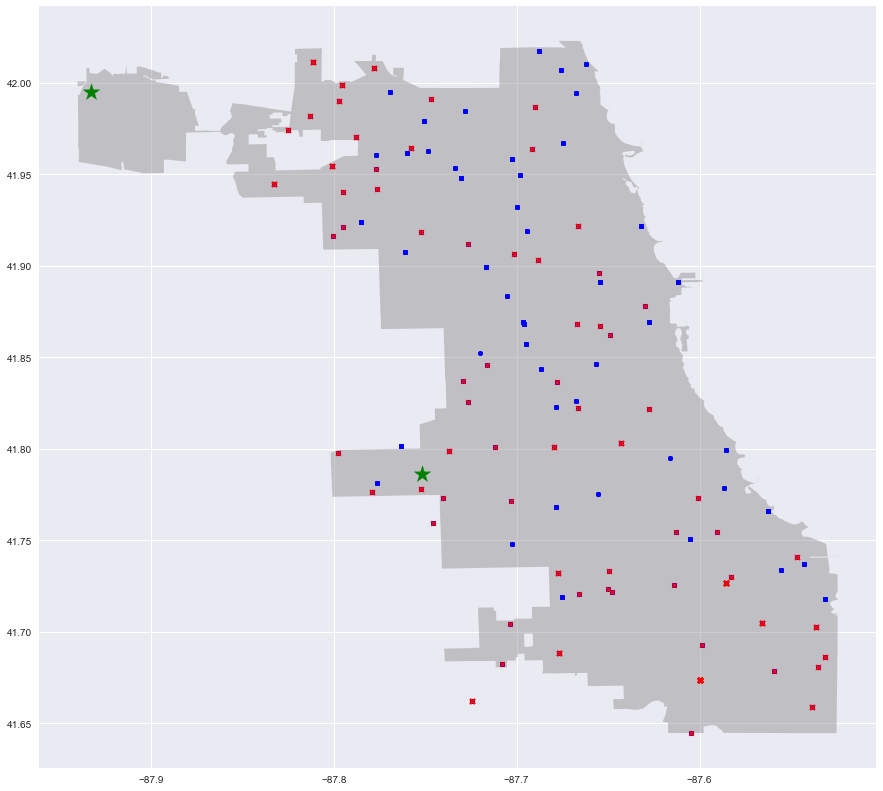

In [78]:
# Combined geo mapping of trap locations, 2 weather stations, and spray area
# Red 'x' - 'WnrPresent' == 1
# Blue 'o' - 'WnrPresent' == 0
# Green '*' - Weather station 1 & 2
# Yellow 'x' - Spray

# Year 2007
yr2007_0_mask = (geo_df['year'] == 2007) & (geo_df['wnvpresent']==0)
yr2007_1_mask = (geo_df['year'] == 2007) & (geo_df['wnvpresent']==1)

fig,ax = plt.subplots(figsize = (15,15))
street_map.plot(ax=ax, alpha = 0.4, color = 'grey')
#geo_spray[geo_spray['Date']!='2011-08-29'].plot(ax=ax, markersize=20, color='yellow',marker='x')
geo_df[yr2007_0_mask].plot(ax=ax, markersize=20, color='blue',marker='o', label='Neg')
geo_df[yr2007_1_mask].plot(ax=ax, markersize=20, color='red',marker='x', label='Pos')
station_df.plot(ax=ax, markersize=300, color='green',marker='*');

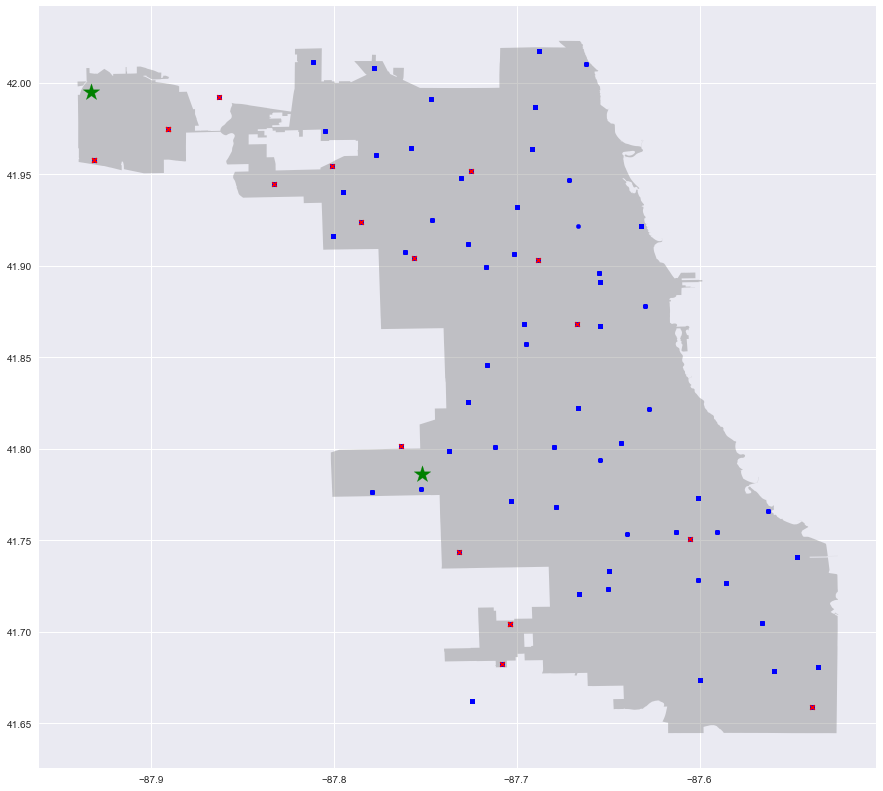

In [79]:
# Combined geo mapping of trap locations, 2 weather stations, and spray area
# Red 'x' - 'WnrPresent' == 1
# Blue 'o' - 'WnrPresent' == 0
# Green '*' - Weather station 1 & 2
# Yellow 'x' - Spray

# Year 2009
yr2009_0_mask = (geo_df['year'] == 2009) & (geo_df['wnvpresent']==0)
yr2009_1_mask = (geo_df['year'] == 2009) & (geo_df['wnvpresent']==1)

fig,ax = plt.subplots(figsize = (15,15))
street_map.plot(ax=ax, alpha = 0.4, color = 'grey')
#geo_spray[geo_spray['Date']!='2011-08-29'].plot(ax=ax, markersize=20, color='yellow',marker='x')
geo_df[yr2009_0_mask].plot(ax=ax, markersize=20, color='blue',marker='o', label='Neg')
geo_df[yr2009_1_mask].plot(ax=ax, markersize=20, color='red',marker='x', label='Pos')
station_df.plot(ax=ax, markersize=300, color='green',marker='*');

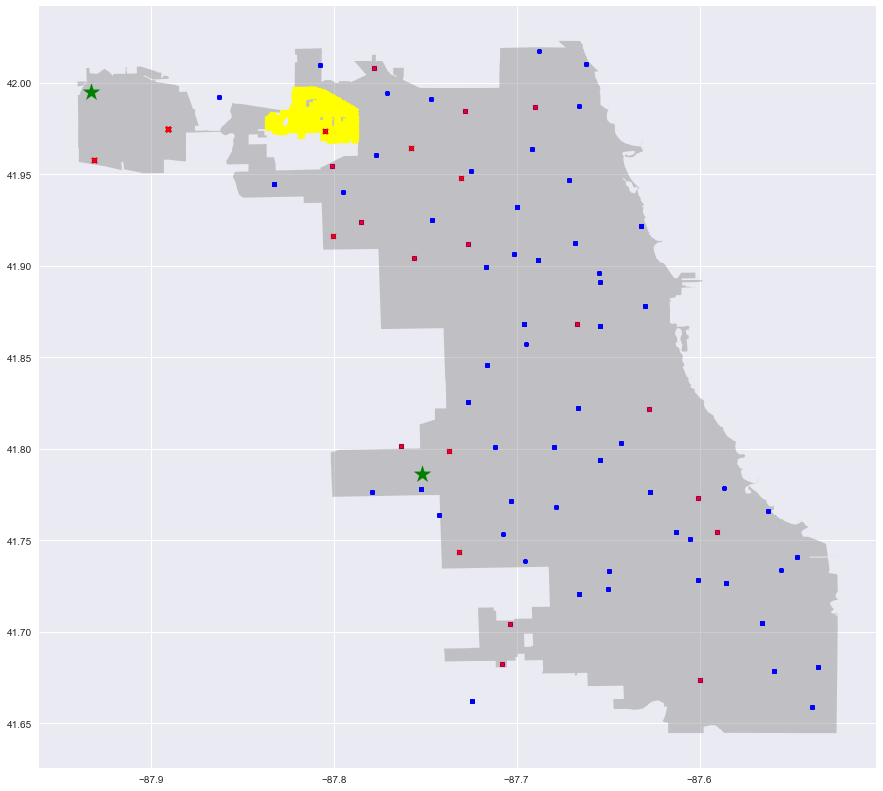

In [80]:
# Combined geo mapping of trap locations, 2 weather stations, and spray area
# Red 'x' - 'WnrPresent' == 1
# Blue 'o' - 'WnrPresent' == 0
# Green '*' - Weather station 1 & 2
# Yellow 'x' - Spray

# Year 2011
yr2011_0_mask = (geo_df['year'] == 2011) & (geo_df['wnvpresent']==0)
yr2011_1_mask = (geo_df['year'] == 2011) & (geo_df['wnvpresent']==1)

fig,ax = plt.subplots(figsize = (15,15))
street_map.plot(ax=ax, alpha = 0.4, color = 'grey')
geo_spray[geo_spray['Date']=='2011-09-07'].plot(ax=ax, markersize=20, color='yellow',marker='x')
geo_df[yr2011_0_mask].plot(ax=ax, markersize=20, color='blue',marker='o', label='Neg')
geo_df[yr2011_1_mask].plot(ax=ax, markersize=20, color='red',marker='x', label='Pos')
station_df.plot(ax=ax, markersize=300, color='green',marker='*');

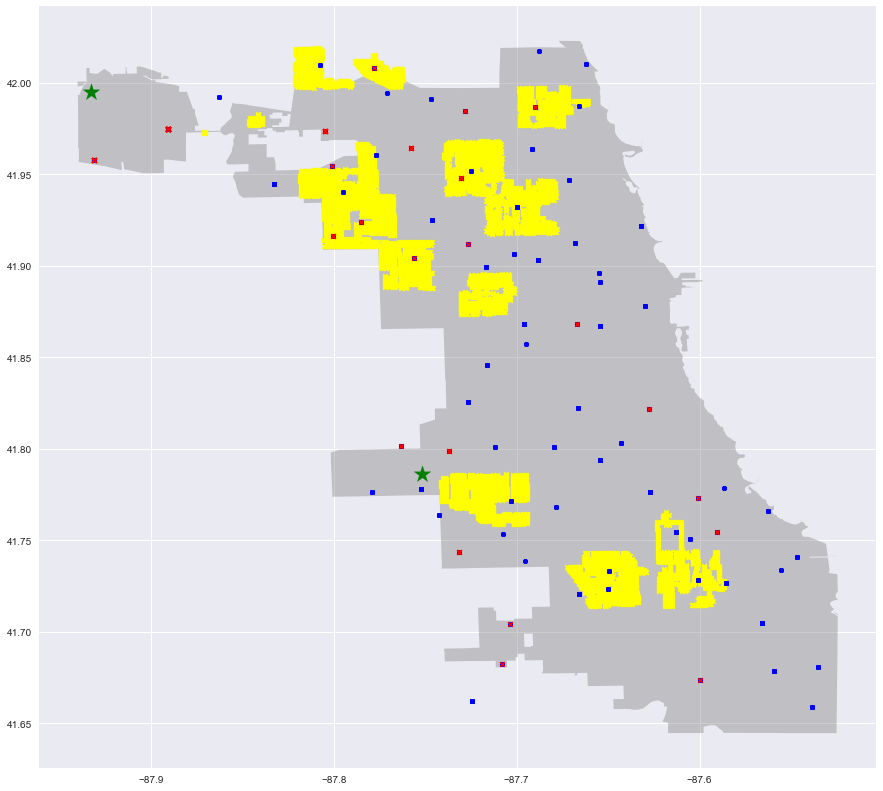

In [81]:
# Combined geo mapping of trap locations, 2 weather stations, and spray area
# Red 'x' - 'WnrPresent' == 1
# Blue 'o' - 'WnrPresent' == 0
# Green '*' - Weather station 1 & 2
# Yellow 'x' - Spray

# Year 2011
yr2013_0_mask = (geo_df['year'] == 2013) & (geo_df['wnvpresent']==0)
yr2013_1_mask = (geo_df['year'] == 2013) & (geo_df['wnvpresent']==1)

fig,ax = plt.subplots(figsize = (15,15))
street_map.plot(ax=ax, alpha = 0.4, color = 'grey')
geo_spray[geo_spray['year']==2013].plot(ax=ax, markersize=20, color='yellow',marker='x')
geo_df[yr2011_0_mask].plot(ax=ax, markersize=20, color='blue',marker='o', label='Neg')
geo_df[yr2011_1_mask].plot(ax=ax, markersize=20, color='red',marker='x', label='Pos')
station_df.plot(ax=ax, markersize=300, color='green',marker='*');